In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

The net force for moving with air friction under gravity is

$$\vec{F}_{\text{net}} = \vec{F}_g + \vec{F}_f = -mg\hat{y} - b|\vec{v}|\vec{v}$$

and noting that $\vec{v} = \dot{x} \hat{x} + \dot{y} \hat{y}$ we get

$$\vec{F}_{\text{net}} = -mg\hat{y} - b\sqrt{\dot{x}^2 + \dot{y}^2}(\dot{x}\hat{x} + \dot{y}\hat{y})$$

or in vector form

$$\vec{F}_{\text{net}} = \begin{bmatrix} - b\sqrt{\dot{x}^2 + \dot{y}^2}\dot{x} \\ -mg - b\sqrt{\dot{x}^2 + \dot{y}^2}\dot{y} \end{bmatrix} $$

Using the fact that $$\vec{F}_{\text{net}} = m\vec{a} = m\left< \ddot{x}, \ddot{y} \right>$$ we get

$$m \begin{bmatrix}\ddot{x} \\ \ddot{y} \end{bmatrix} =  \begin{bmatrix} - b\sqrt{\dot{x}^2 + \dot{y}^2}\dot{x} \\ -mg - b\sqrt{\dot{x}^2 + \dot{y}^2}\dot{y} \end{bmatrix} $$

and thus have two coupled differential equations

$$\ddot{x} = - \frac{b}{m}\sqrt{\dot{x}^2 + \dot{y}^2}\dot{x}$$
$$\ddot{y} = -g - \frac{b}{m}\sqrt{\dot{x}^2 + \dot{y}^2}\dot{y}$$

Defining $x' = x/g$ and $y'=y/g$ we get

$$\ddot{x'} = - \frac{bg}{m}\sqrt{\dot{x'}^2 + \dot{y'}^2}\dot{x'}$$
$$\ddot{y'} = -1 - \frac{bg}{m}\sqrt{\dot{x'}^2 + \dot{y'}^2}\dot{y'}$$

We can thus solve this equation for different values of $B \equiv bg/m$ to get $x'(t)$ and $y'(t)$ which are directly proportional to $x(t)$ and $y(t)$ (we get the same shape). We will drop the primes for now on but recall that there is the divided by $g$ factor.

In python we can only solve systems of first order ODEs, so defining $v_x=\dot{x}$ and $v_y=\dot{y}$ we get a system of 4 coupled first order ODEs.

* $\dot{x} = v_x$
* $\dot{v_x} = - B\sqrt{\dot{x}^2 + \dot{y}^2}\dot{x}$
* $\dot{y} = v_y$
* $\dot{v_y} = - B\sqrt{\dot{x}^2 + \dot{y}^2}\dot{y}$

Define $\vec{S} = \left<x, v_x, y, v_y\right>$. To solve ODEs in python, need to write a funciton that takes in $\vec{S}$ and time $t$, and returns $d\vec{S}/dt$. In other words we want $f$ in 

$$\frac{d\vec{S}}{dt} = f(\vec{S}, t)$$

In [2]:
# Define function f above
def dSdt(t,S,B):
    x, vx, y, vy = S
    return [vx,
            -B*np.sqrt(vx**2+vy**2)*vx, 
            vy,
            -1-B*np.sqrt(vx**2+vy**2)*vy]

Define friction `B`, initial velocity `V`, and a few angles `t1, t2, t3`

In [3]:
B = 1
V = 1
t1 = 40 *np.pi / 180
t2 = 45 *np.pi / 180
t3 = 50 *np.pi / 180

Solve the ODE using scipy's `solve_ivp` method. Function takes in the $d\vec{S}/dt$ function, time period to solve over `[0,2]`seconds, initial conditions, `t_eval` to evaluate on, and addition arguments `B` (friction force) for the function. Also we set  

In [4]:
sol1 = solve_ivp(dSdt, [0, 2], y0=[0,V*np.cos(t1),0,V*np.sin(t1)], t_eval=np.linspace(0,2,1000), args=(B,)) # atol=1e-7, rtol=1e-4)
sol2 = solve_ivp(dSdt, [0, 2], y0=[0,V*np.cos(t2),0,V*np.sin(t2)], t_eval=np.linspace(0,2,1000), args=(B,)) #atol=1e-7, rtol=1e-4)
sol3 = solve_ivp(dSdt, [0, 2], y0=[0,V*np.cos(t3),0,V*np.sin(t3)], t_eval=np.linspace(0,2,1000), args=(B,)) #atol=1e-7, rtol=1e-4)

Plot a few of the solutions

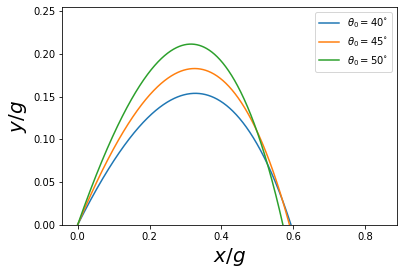

In [5]:
plt.plot(sol1.y[0],sol1.y[2], label=r'$\theta_0=40^{\circ}$')
plt.plot(sol2.y[0],sol2.y[2], label=r'$\theta_0=45^{\circ}$')
plt.plot(sol3.y[0],sol3.y[2], label=r'$\theta_0=50^{\circ}$')
plt.ylim(bottom=0)
plt.legend()
plt.xlabel('$x/g$', fontsize=20)
plt.ylabel('$y/g$', fontsize=20)
plt.show()

This function gets the distance $x/g$ that the ball traveled before it hits the ground when traveling at an initial velocity $V$.

In [6]:
def get_distance(angle, B, V=1, t=2):
    v0x = V*np.cos(angle*np.pi/180)
    v0y = V*np.sin(angle*np.pi/180)
    sol = solve_ivp(dSdt, [0, t], y0=[0,v0x,0,v0y], t_eval=np.linspace(0,t,10000), args=(B,), atol=1e-7, rtol=1e-4)
    just_above_idx = np.where(np.diff(np.sign(sol.y[2])) < 0)[0][0]
    just_below_idx = just_above_idx + 1
    x_loc = (sol.y[0][just_above_idx] + sol.y[0][just_below_idx])/2
    return x_loc

Look at the two cases above

In [7]:
print(f'Launch angle 45 degrees distance travelled:  {get_distance(45, B=1, V=1)}')
print(f'Launch angle 40 degrees distance travelled:  {get_distance(40, B=1, V=1)}')

Launch angle 45 degrees distance travelled:  0.5890479196032461
Launch angle 40 degrees distance travelled:  0.5933703230246123


Lets find these distances for a bunch of angles:

In [8]:
angles = np.linspace(15, 60, 200)
x_locs = np.vectorize(get_distance)(angles, B=1)

Plot the distance travelled before hitting the ground over a bunch of different launch angles (at $V=1$)

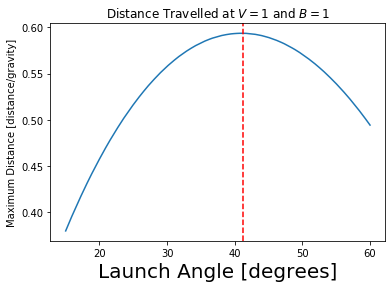

In [9]:
plt.plot(angles, x_locs)
plt.xlabel('Launch Angle [degrees]', fontsize=20)
plt.ylabel('Maximum Distance [distance/gravity]')
plt.axvline(angles[np.argmax(x_locs)], ls='--', color='r')
plt.title('Distance Travelled at $V=1$ and $B=1$')
plt.show()

Lets find the angle that gives the maximum distance as a function of $B$. We will do this for two values of $V$: $V=1$ and $V=2$:

In [10]:
V1 = 1
V2 = 2
angles = np.linspace(35, 45, 200)
Bs =  np.linspace(0, 1, 50)

results_v1 = [np.vectorize(get_distance)(angles, B=B, V=V1) for B in Bs]
opt_angles_v1 = [angles[np.argmax(result)] for result in results_v1]
results_v2 = [np.vectorize(get_distance)(angles, B=B, V=V2, t=6) for B in Bs]
opt_angles_v2 = [angles[np.argmax(result)] for result in results_v2]

Plot the results

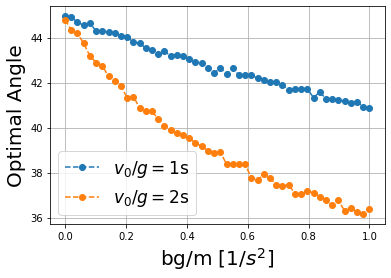

In [12]:
plt.plot(Bs, opt_angles_v1, 'o--', label='$v_0/g=1$s')
plt.plot(Bs, opt_angles_v2, 'o--', label='$v_0/g=2$s')
plt.legend(fontsize=17)
plt.xlabel('bg/m [1/$s^2$]', fontsize=20)
plt.ylabel('Optimal Angle', fontsize=20)
plt.grid()

How does this correspond to regular objects? Lets look at a golf ball and a soccer ball:

Now $b = \frac{1}{2} \rho A C_d$ and 

* for a golf ball, $m=0.045~\text{kg}$ and $r=0.021~\text{m}$ and $C_d \approx 0.5$
* for a soccer ball $m=0.45~\text{kg}$ and $r=0.11~\text{m}$ and $C_d \approx 0.2$
* for  air, $\rho = 1.225~\text{kg/m}$

The formula for $B$ becomes

$$B \equiv \frac{bg}{m} = \frac{1}{2}\frac{\rho \pi r^2 C_d g}{m}$$

"Sources" 

https://www.scirp.org/journal/paperinformation.aspx?paperid=85529

https://www.brunel.ac.uk/~spstnpl/LearningResources/SoccerKickLab.pdf

https://athleticlift.com/how-fast-can-you-kick-soccer-ball/#:~:text=From%20research%2C%20it%20shows%20that%20youth%20soccer%20athletes,kick%20a%20soccer%20ball%20through%20your%20phone%20camera.

In [13]:
rho = 1.225
g = 9.81

# Golf
r = 0.021
Cd = 0.5
m = 0.045
B_golf = 0.5 * rho * np.pi * r**2 * Cd * g /m

# Soccer
r = 0.22 / 2
Cd = 0.2
m = 0.45
B_soc = 0.5 * rho * np.pi * r**2 * Cd * g /m

Plot the results next to the values of $B$ for the soccer and golf ball. Note that $V=2$ corresponds to kicking a soccer ball at $v_0/g = 2~\text{s} \implies v_0 \approx 20~\text{m/s} \approx 72~\text{km/h}$ which is representative of a true soccer kick:

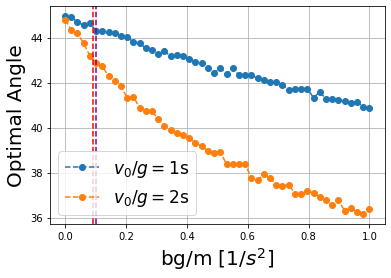

In [15]:
plt.plot(Bs, opt_angles_v1, 'o--', label='$v_0/g=1$s')
plt.plot(Bs, opt_angles_v2, 'o--', label='$v_0/g=2$s')
plt.legend(fontsize=17)
plt.xlabel('bg/m [1/$s^2$]', fontsize=20)
plt.ylabel('Optimal Angle', fontsize=20)
plt.grid()
plt.axvline(B_golf, ls='--', color='r')
plt.axvline(B_soc, ls='--', color='purple')